In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator

In [2]:
saveState = False
colors = list(mcolors.TABLEAU_COLORS.values())
patNumbers = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

medianErrorsStages = np.zeros(shape=(12, 5)) # shape=(patients, reg_stages)
pointErrors = np.zeros(shape=(12, 5, 10)) # shape=(patients, reg_stages, point_errors
runTime = np.zeros(shape=(12, 3))
lastIterMetrics = np.zeros(shape=(12, 3))

for idx, num in enumerate(patNumbers):
    errorPath = f"input_files\\pacient_{num}\\registration\\"

    preFile = np.load(f"{errorPath}gradient\\pacient{num}PreErrors.npz")
    initialFile = np.load(f"{errorPath}gradient\\pacient{num}InitialErrors.npz")
    gradFile = np.load(f"{errorPath}gradient\\pacient{num}RegErrors.npz")
    gradLineFile = np.load(f"{errorPath}gradientline\\pacient{num}RegErrors.npz")
    gradLbfFile = np.load(f"{errorPath}gradientlbf\\pacient{num}RegErrors.npz")
    
    gradRegFile = np.load(f"{errorPath}gradient\\pacient{num}RegParams.npz")
    gradLineRegFile = np.load(f"{errorPath}gradientline\\pacient{num}RegParams.npz")
    gradLbfRegFile = np.load(f"{errorPath}gradientlbf\\pacient{num}RegParams.npz")
    
    pointErrors[idx, 0, :] = preFile["preErrors"]
    pointErrors[idx, 1, :] = initialFile["initialErrors"]
    pointErrors[idx, 2, :] = gradFile["regErrors"][-1, :]
    pointErrors[idx, 3, :] = gradLineFile["regErrors"][-1, :]
    pointErrors[idx, 4, :] = gradLbfFile["regErrors"][-1, :]

    # median errors per patient and registration stage
    medianErrorsStages[idx, 0] = preFile["preMedians"] # before initialization
    medianErrorsStages[idx, 1] = initialFile["initialMedians"] # after initialization
    medianErrorsStages[idx, 2] = gradFile["regMedians"][-1] # gradient 
    medianErrorsStages[idx, 3] = gradLineFile["regMedians"][-1] # gradient line 
    medianErrorsStages[idx, 4] = gradLbfFile["regMedians"][-1] # lbfgs
    
    lastIterMetrics[idx, 0] = gradRegFile["metricValues"][-1] # gradient
    lastIterMetrics[idx, 1] = gradLineRegFile["metricValues"][-1] # gradient line
    lastIterMetrics[idx, 2] = gradLbfRegFile["metricValues"][-1] # lbfgs
    
    runTime[idx, 0] = gradRegFile["execTime"]
    runTime[idx, 1] = gradLineRegFile["execTime"]
    runTime[idx, 2] = gradLbfRegFile["execTime"]
    
    del(preFile, initialFile, gradFile, gradLineFile, gradLbfFile, gradRegFile,
        gradLineRegFile, gradLbfRegFile)

regStages = ["Před inicializací", "Po inicializaci", "Gradientní\nsestup", 
             "Gradientní sestup\nse zl. řezem", "BFGS s\nomezenou pamětí"]
regCols = ["pre", "initial", "grad", 
             "grad_line", "grad_lbf"]
regLabels = ["Před inicializací", "Po inicializaci", "Gradientní sestup", 
             "Gradientní sestup se zl. řezem", "BFGS s omezenou pamětí"]

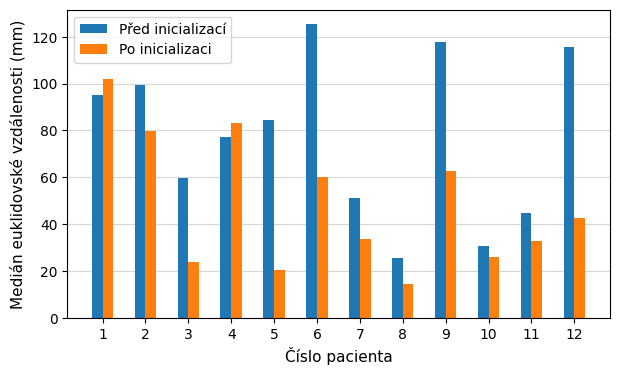

In [91]:
def plotMedianErrorBars(initial_median_errors, labels, reg_stage, save=False):

    median_error_groups = {key:val for (key, val) in zip(labels, np.transpose(initial_median_errors))}

    bar_numbers = np.arange(1, initial_median_errors.shape[0] + 1)
    width = 0.25
    multiplier = 0

    fig_bar, ax_bar = plt.subplots(1, 1, figsize=(7, 4))

    for group, median_error in median_error_groups.items():
        offset = width * multiplier
        ax_bar.bar(bar_numbers + offset, median_error, width, label=group)
        multiplier += 1

    if initial_median_errors.shape[-1] == 2:
        ax_bar.set_xticks(bar_numbers + (width / 2), bar_numbers)
    else:
        ax_bar.set_xticks(bar_numbers + width, bar_numbers)

    ax_bar.set_xlabel("Číslo pacienta", fontsize=11)
    ax_bar.set_ylabel("Medián euklidovské vzdálenosti (mm)", fontsize=11)
    ax_bar.legend()

    #ax_bar.set_ylim([0, 30])
    ax_bar.yaxis.grid(alpha=0.5)
    ax_bar.set_axisbelow(True)

    plt.show()

    if save:
        fig_bar.savefig(f"graficke_vystupy\\{reg_stage}RegErrors.pdf", 
                        bbox_inches="tight")
        fig_bar.savefig(f"graficke_vystupy\\{reg_stage}RegErrors.svg", 
                bbox_inches="tight")
    
plotMedianErrorBars(medianErrorsStages[:, :2], regLabels[:2], "before", save=True)
#plotMedianErrorBars(medianErrorsStages[:, 2:], regLabels[2:], "after", save=True)

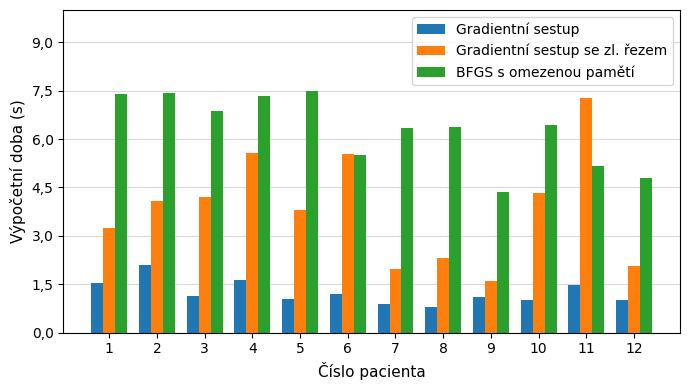

In [92]:
def plotRunTimeBars(run_time, optims, save):
    run_time_groups = {key:val for (key, val) in zip(optims, run_time.T)}

    x = np.arange(1, 12 + 1, dtype=int)
    width = 0.25
    multipler = 0

    fig_runtimes, ax_runtimes = plt.subplots(1, 1, figsize=(7, 4))
    
    for group, run_time in run_time_groups.items():
        offset = width * multipler
        rects = ax_runtimes.bar(x + offset, run_time, width, label=group)
        multipler += 1
    
    yticks = np.arange(0, 15, 1.5)
    yticks_labels = [str(tick).replace(".", ",") for tick in yticks]
    ax_runtimes.set_xticks(x + width, x)
    ax_runtimes.set_yticks(yticks, yticks_labels)

    ax_runtimes.set_xlabel("Číslo pacienta", fontsize=11)
    ax_runtimes.set_ylabel("Výpočetní doba (s)", fontsize=11)
    ax_runtimes.set_ylim([0, 10])
    ax_runtimes.yaxis.grid(alpha=0.5)
    ax_runtimes.legend()
    
    fig_runtimes.tight_layout()
    ax_runtimes.set_axisbelow(True)
    plt.show()
    
    if save:
        fig_runtimes.savefig("graficke_vystupy\\runtimePatients.pdf", bbox_inches="tight")
        fig_runtimes.savefig("graficke_vystupy\\runtimePatients.svg", bbox_inches="tight")
    
plotRunTimeBars(runTime, regLabels[2:], save=True)

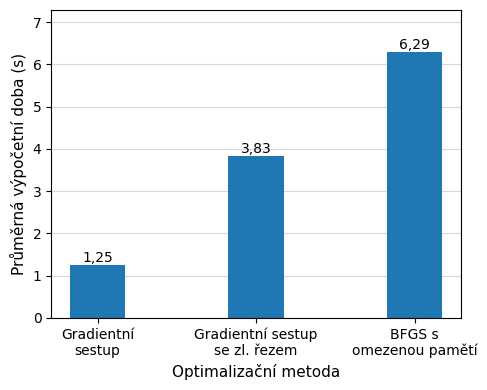

In [93]:
def plotMeanRuntime(run_time, optims, save=False):
    mean_runtimes = np.mean(run_time, axis=0)

    bar_labels = [f"{val:,.2f}".replace(".", ",") for val in mean_runtimes]
    
    fig_runtime, ax_runtime = plt.subplots(1, 1, figsize=(5, 4))
    
    rects = ax_runtime.bar(np.arange(len(mean_runtimes)), mean_runtimes, width=0.35)
    ax_runtime.bar_label(rects, labels=bar_labels)
    ax_runtime.set_xticks(np.arange(len(mean_runtimes), dtype=int), optims)
    ax_runtime.set_xlabel("Optimalizační metoda", fontsize=11)
    ax_runtime.set_ylabel("Průměrná výpočetní doba (s)", fontsize=11)
    ax_runtime.yaxis.grid(True, alpha=0.5)
    ax_runtime.set_ylim([0, rects.datavalues.max() + 1])
    ax_runtime.set_axisbelow(True)

    
    fig_runtime.tight_layout() 
    plt.show()
    
    if save:
        fig_runtime.savefig("graficke_vystupy\\meanRuntime.svg", bbox_inches="tight")
        fig_runtime.savefig("graficke_vystupy\\meanRuntime.pdf", bbox_inches="tight")
    
    
plotMeanRuntime(runTime, regStages[2:], save=True)

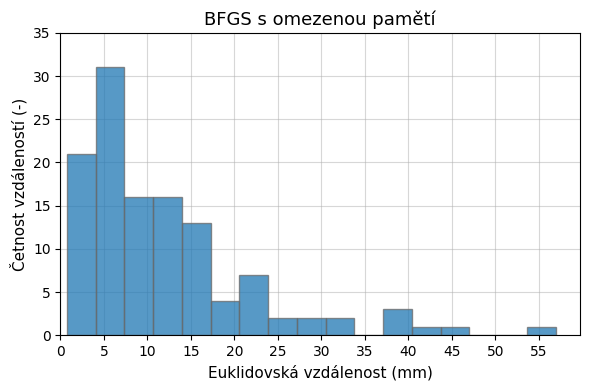

In [112]:
def plotErrorHist(error_values, reg_phase, bin_width=17, 
                   hist_type="initial", bin_color="#1f77b4", save=False):
    
    fig_hist, ax_hist = plt.subplots(1, 1, figsize=(6, 4))


    ax_hist.hist(error_values, bins=bin_width, alpha=0.75, color=bin_color, 
                edgecolor="dimgray", linewidth=1.)
    ax_hist.grid(alpha=0.5)
    ax_hist.set_xlabel("Euklidovská vzdálenost (mm)", fontsize=11)
    ax_hist.set_title(reg_phase, fontsize=13)
    ax_hist.set_ylim([0, None])
    ax_hist.set_xlim([0, None])
    ax_hist.set_ylabel("Četnost vzdáleností (-)", fontsize=11)
    ax_hist.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_hist.set_xticks(np.arange(0, error_values.max() + 2, 5))
    ax_hist.set_yticks(np.arange(0, 36, 5))
    ax_hist.set_axisbelow(True)
    # ax_hist.set_title("Rozložení míry nepřesností")
    # ax_hist.legend()
    fig_hist.tight_layout()
    plt.show()

    if save:
        fig_hist.savefig(f"graficke_vystupy\\{hist_type}ErrorsHist.pdf", bbox_inches="tight")
        fig_hist.savefig(f"graficke_vystupy\\{hist_type}ErrorsHist.svg", bbox_inches="tight")
        
plotErrorHist(pointErrors[:, 4].ravel(), regLabels[4], hist_type="gradientlbf",
              bin_width=17, bin_color=colors[0], save=True)

In [1]:
patientNumber = "12"
regMethodDir = "gradientline"
regMethod = ""
regMethodNum = None

if regMethodDir == "gradient":
    regMethod = regLabels[2]
    regMethodNum = 0
elif regMethodDir == "gradientline":
    regMethod = regLabels[3]
    regMethodNum = 1
elif regMethodDir == "gradientlbf":
    regMethod = regLabels[4]
    regMethodNum = 2

dirpath = f"{os.getcwd()}\\input_files\\pacient_{patientNumber}\\registration\\{regMethodDir}\\pacient{patientNumber}"

preErrorsFile = np.load(f"{dirpath}PreErrors.npz")
initialErrorsFile = np.load(f"{dirpath}InitialErrors.npz")
regErrorsFile = np.load(f"{dirpath}RegErrors.npz")
regParamsFile = np.load(f"{dirpath}RegParams.npz")
colors = list(mcolors.TABLEAU_COLORS.values())

preErrorValues = {key: preErrorsFile[key] for key in preErrorsFile.files}
initialErrorValues = {key: initialErrorsFile[key] for key in initialErrorsFile.files}
regErrorValues = {key: regErrorsFile[key] for key in regErrorsFile.files}
regParamValues = {key: regParamsFile[key] for key in regParamsFile.files}

patientMedianErrors = []
patientMetricValues = []

for method in ("gradient", "gradientline", "gradientlbf"):
    metric_values_ = np.load(f"input_files\\pacient_{patientNumber}\\registration\\{method}\\"
                            f"pacient{patientNumber}RegParams.npz")["metricValues"]
    median_errors_ = np.load(f"input_files\\pacient_{patientNumber}\\registration\\{method}\\"
                            f"pacient{patientNumber}RegErrors.npz")["regMedians"]
    
    patientMetricValues.append(metric_values_)
    patientMedianErrors.append(median_errors_)

NameError: name 'regLabels' is not defined

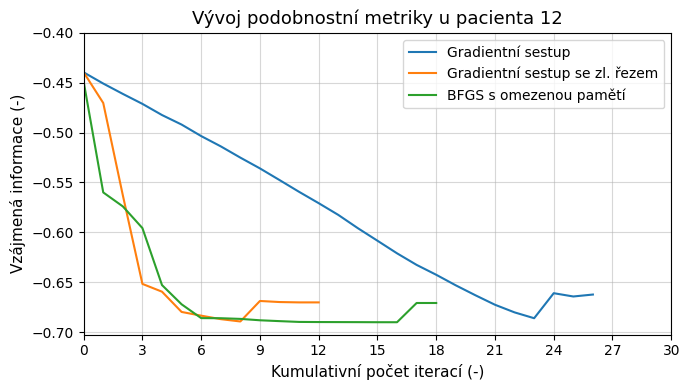

In [357]:
def plotAllMetrics(metric_values, pat_number, reg_stages, save=False):
    
    fig_metrics, ax_metrics = plt.subplots(1, 1, figsize=(7, 4))
    
    for values, label in zip(metric_values, reg_stages):
        ax_metrics.plot(values, label=label)
    ax_metrics.legend(loc="best")
    ax_metrics.grid(alpha=0.5)
    ax_metrics.set_xlabel("Kumulativní počet iterací (-)", fontsize=11)
    ax_metrics.set_ylabel("Vzájmená informace (-)", fontsize=11)
    ax_metrics.set_title(f"Vývoj podobnostní metriky u pacienta {int(pat_number)}", fontsize=13)
    
    ax_metrics.set_xticks(np.arange(0, len(metric_values[0]) + 5, 3))
    ax_metrics.set_yticks(np.arange(-0.40, -0.71, -0.05))
    ax_metrics.set_xlim([0, None])
    fig_metrics.tight_layout()
    plt.show()
    
    if save:
        fig_metrics.savefig(f"graficke_vystupy\\pacient_{pat_number}\\pacient{pat_number}AllOptims.pdf", 
                            bbox_inches="tight")
        fig_metrics.savefig(f"graficke_vystupy\\pacient_{pat_number}\\pacient{pat_number}AllOptims.svg", 
                    bbox_inches="tight")

plotAllMetrics(patientMetricValues, patientNumber, regLabels[2:], save=True)

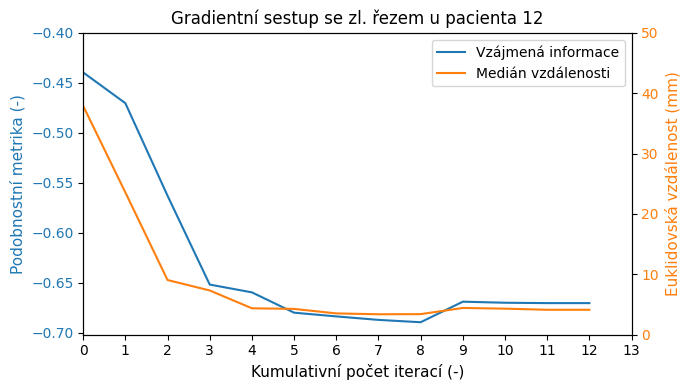

In [353]:
def plotMetricAndError(metric_values, median_errors,
                       reg_method, pat_number, save=False):
    
    fig_metric_tre, ax_metric_tre = plt.subplots(1, 1, figsize=(7, 4))
    twin1 = ax_metric_tre.twinx()
    
    color1 = "tab:blue"
    color2 = "tab:orange"
    iters = np.arange(0, len(metric_values))
    plot1, = ax_metric_tre.plot(iters, metric_values, color=color1, label="Vzájmená informace")
    plot2, = twin1.plot(iters, median_errors, color=color2, label="Medián vzdálenosti", ls="-")
    
    ax_metric_tre.set_xlabel("Kumulativní počet iterací (-)", fontsize=11)
    ax_metric_tre.set_ylabel("Podobnostní metrika (-)", fontsize=11, color=color1)
    ax_metric_tre.tick_params(axis="y", labelcolor=color1)
    twin1.set_ylabel("Euklidovská vzdálenost (mm)", fontsize=11, color=color2)
    twin1.tick_params(axis="y", labelcolor=color2)
    ax_metric_tre.set_xticks(np.arange(0, iters.shape[0] + 1, 1))
    ax_metric_tre.set_yticks(np.arange(-0.40, -0.71, -0.05))
    twin1.set_yticks(np.arange(0, median_errors_.max() + 10, 10))
    
    ax_metric_tre.set_xlim([0, None])
    ax_metric_tre.set_ylim([None, None])
    ax_metric_tre.set_title(f"{reg_method} u pacienta {int(pat_number)}")
    ax_metric_tre.legend(handles=[plot1, plot2])
    
    fig_metric_tre.tight_layout()
    plt.show()
    
    if save:
        fig_metric_tre.savefig(f"graficke_vystupy\\pacient_{pat_number}\\pacient{pat_number}MetricAndError.pdf", 
                               bbox_inches="tight")
        fig_metric_tre.savefig(f"graficke_vystupy\\pacient_{pat_number}\\pacient{pat_number}MetricAndError.svg", 
                               bbox_inches="tight")

plotMetricAndError(patientMetricValues[regMethodNum], patientMedianErrors[regMethodNum], 
                   regMethod, patientNumber, save=True)

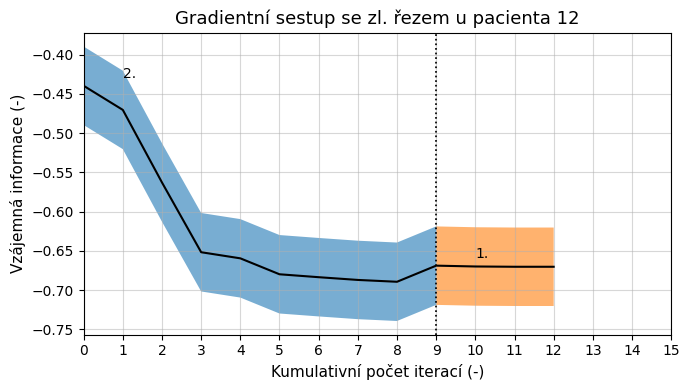

In [359]:
def plotMetricValues(metric_values, multires_iters, shrink_factors, smooth_sigmas,
                     pat_number, reg_method, save=False):
    iters = np.arange(0, len(metric_values))
    
    fig_metric, ax_metric = plt.subplots(1, 1, figsize=(7, 4))
    ax_metric.plot(iters, metric_values, label="Vzájemná informace", c="black")

    for indx, multi_iter in enumerate(multires_iters):
        if multi_iter != multires_iters[-1]:
            ax_metric.fill_between(iters[multi_iter:multires_iters[indx + 1] + 1],
                                   metric_values[multi_iter:multires_iters[indx + 1] + 1] - 0.05,
                                   metric_values[multi_iter:multires_iters[indx + 1] + 1] + 0.05,
                                   facecolor=colors[indx], alpha=0.6)
        else:
            ax_metric.fill_between(iters[multi_iter:iters[-1] + 1],
                                   metric_values[multi_iter:iters[-1] + 1] - 0.05,
                                   metric_values[multi_iter:iters[-1] + 1] + 0.05,
                                   facecolor=colors[indx], alpha=0.6)
     
    ax_metric.set_xticks(np.arange(0, iters.shape[0] + 3, 1))
    ax_metric.set_yticks(np.arange(-0.40, -0.76, -0.05))
    ax_metric.grid(alpha=0.5)
    
    ax_metric.set_xlim([0, None])
    ax_metric.set_ylim([None, None])
    ax_ylim = ax_metric.get_ylim()
    ax_xlim = ax_metric.get_xlim()
    ax_metric.vlines(multires_iters, 
                     ax_ylim[0], # metric_values[multires_iters] - 0.075 
                     ax_ylim[1], # metric_values[multires_iters] + 0.075 
                     ls="dotted", lw=1.25, colors="black")
    
    levels = [level for level in range(len(multires_iters), 0, -1)]
    for level, multi_iter in zip(levels, multires_iters):
        ax_metric.annotate(f"{level}.", (multi_iter + 1,
                                         metric_values[multi_iter] + 0.01))
    # param_text = f"Parametry registračních úrovní:\n S = {shrink_factors}\n $\sigma^2$ = {smooth_sigmas}"
    # ax_metric.text(iters[4], -0.6, param_text, bbox=dict(edgecolor="k",
    #                                                      facecolor="none"))
    
    # ax_metric.set_xlim([0, None])
    # ax_metric.set_ylim([None, None])
        # ax_metric.annotate(f"{level}. S = {shrink}\n    $\sigma^2$ = {smooth}", 
        #                   (multi_iter + 2, ax_ylim[0] + 0.01))
    
    ax_metric.set_xlabel("Kumulativní počet iterací (-)", fontsize=11)
    ax_metric.set_ylabel("Vzájemná informace (-)", fontsize=11)
    ax_metric.set_title(f"{reg_method} u pacienta {int(pat_number)}", fontsize=13)
    #ax_metric.legend()
    fig_metric.tight_layout()
    plt.show()
    
    if save:
        fig_metric.savefig(f"graficke_vystupy\\pacient_{pat_number}\\pacient{pat_number}BestMetric.pdf", 
                           bbox_inches="tight")
        fig_metric.savefig(f"graficke_vystupy\\pacient_{pat_number}\\pacient{pat_number}BestMetric.svg", 
                           bbox_inches="tight")


plotMetricValues(regParamValues["metricValues"], regParamValues["multiresIters"], 
                 regParamValues["shrinkFactors"], regParamValues["smoothingSigmas"], 
                 patientNumber, regMethod, save=True)

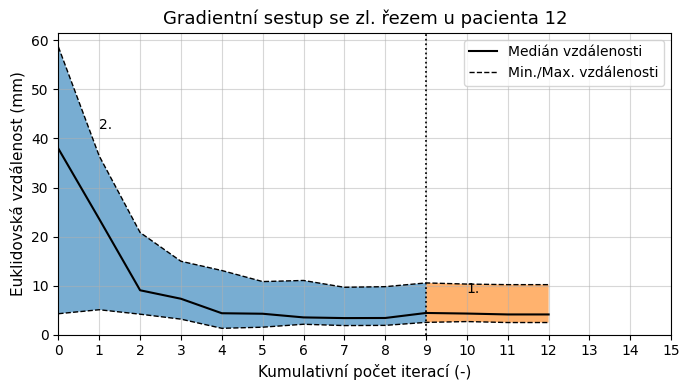

In [362]:
def plotRegistrationErrors(median_errors, min_errors, max_errors, 
                           metric_values, multires_iters, 
                           pat_number, reg_method, save=False):
    iters = np.arange(0, len(metric_values))
    fig_tre, ax_tre = plt.subplots(1, 1, figsize=(7, 4))
    ax_tre.plot(iters, median_errors, color="black", label="Medián vzdálenosti")
    ax_tre.plot(iters, min_errors, c="black", ls="--", lw=1., label="Min./Max. vzdálenosti")
    ax_tre.plot(iters, max_errors, c="black", ls="--", lw=1.)
    
    for indx, multi_iter in enumerate(multires_iters):
        if multi_iter != multires_iters[-1]:
            ax_tre.fill_between(iters[multi_iter:multires_iters[indx + 1] + 1],
                                   min_errors[multi_iter:multires_iters[indx + 1] + 1],
                                   max_errors[multi_iter:multires_iters[indx + 1] + 1],
                                   facecolor=colors[indx], alpha=0.6)
        else:
            ax_tre.fill_between(iters[multi_iter:iters[-1] + 1],
                                   min_errors[multi_iter:iters[-1] + 1],
                                   max_errors[multi_iter:iters[-1] + 1],
                                   facecolor=colors[indx], alpha=0.6)
    ax_tre.set_xticks(np.arange(0, iters.shape[0] + 3, 1))
    ax_tre.set_yticks(np.arange(0, max_errors.max() + 10, 10))
    
    ax_tre.set_xlim([0, None])
    ax_tre.set_ylim([0, None])
    ax_ylim = ax_tre.get_ylim()
    ax_tre.vlines(multires_iters, ax_ylim[0], ax_ylim[1], 
                  ls="dotted", lw=1.25, colors="black") # min_errors[multires_iters], max_errors[multires_iters], 

    levels = [level for level in range(len(multires_iters), 0, -1)]
    for level, multi_iter in zip(levels, multires_iters):
        ax_tre.annotate(f"{level}.", (multi_iter + 1, median_errors[multi_iter] + 4))

    ax_tre.set_xlabel("Kumulativní počet iterací (-)", fontsize=11)
    ax_tre.set_ylabel("Euklidovská vzdálenost (mm)", fontsize=11)
    ax_tre.set_title(f"{reg_method} u pacienta {int(pat_number)}", fontsize=13)
    # ax_tre.set_xticks(np.arange(0, iters.shape[0] + 3, 5))
    # ax_tre.set_yticks(np.arange(0, max_errors.max() + 5, 15))
    # ax_tre.set_xlim([0, None])
    # ax_tre.set_ylim([0, None])
    ax_tre.grid(alpha=0.5)
    ax_tre.legend()
    fig_tre.tight_layout()
    
    plt.show()
    
    if save:
        fig_tre.savefig(f"graficke_vystupy\\pacient_{pat_number}\\pacient{pat_number}BestTre.pdf", bbox_inches="tight")
        fig_tre.savefig(f"graficke_vystupy\\pacient_{pat_number}\\pacient{pat_number}BestTre.svg", bbox_inches="tight")


plotRegistrationErrors(regErrorValues["regMedians"], regErrorValues["regMins"], 
                       regErrorValues["regMaxs"], regParamValues["metricValues"], 
                       regParamValues["multiresIters"], patientNumber, regMethod, save=True)

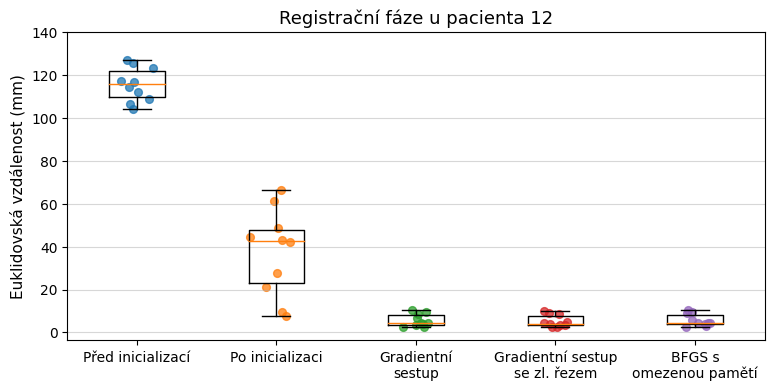

In [366]:
def plotPatientErrorBox(patient_errors, reg_stages, pat_number, save=False):
    fig_box, ax_box = plt.subplots(1, 1, figsize=(9, 4))

    ax_box.boxplot(patient_errors, labels=reg_stages, widths=0.4, showfliers=False)
    scatter_xaxis = []
    for indx, col in enumerate(range(patient_errors.shape[1])):
        scatter_xaxis.append(np.random.normal(indx + 1, 0.05, size=patient_errors.shape[0]))
    
    for xaxis, values, color in zip(scatter_xaxis, patient_errors.T, palette):
        ax_box.scatter(xaxis, values, c=color, alpha=0.75, marker=".", s=125)

    ax_box.yaxis.grid(True, alpha=0.5)
    ax_box.set_title(f"Registrační fáze u pacienta {int(pat_number)}", fontsize=13)
    ax_box.set_ylabel("Vzdálenost mezi páry bodů (mm)", fontsize=11)
    ax_box.set_ylabel("Euklidovská vzdálenost (mm)", fontsize=11)
    ax_box.set_yticks(np.arange(0, 141, 20))
    plt.show()

    if save:
        fig_box.savefig(f"graficke_vystupy\\pacient_{pat_number}\\pacient{pat_number}RegStages.pdf", 
                        bbox_inches="tight")
        fig_box.savefig(f"graficke_vystupy\\pacient_{pat_number}\\pacient{pat_number}RegStages.svg", 
                bbox_inches="tight")
        
palette = colors[:5]
patientErrors = np.array([pointErrors[int(patientNumber) - 1, 0, :],
                          pointErrors[int(patientNumber) - 1, 1, :],
                          pointErrors[int(patientNumber) - 1, 2, :],
                          pointErrors[int(patientNumber) - 1, 3, :],
                          pointErrors[int(patientNumber) - 1, 4, :]]).T
plotPatientErrorBox(patientErrors, regStages, patientNumber, save=True)

In [3]:
errors = np.array([[19.12, 10.68, 8.88, 7.59],
                   [10.59, 9.50, 10.11, 11.02],
                   [10.34, 11.31, 12.84, 11.45]]).T
exectime = np.array([[15.34, 4.58, 1.33, 1.15],
                     [6.67, 7.47, 8.57, 4.12],
                     [6.94, 7.12, 4.82, 5.91]]).T
colors = list(mcolors.TABLEAU_COLORS.values())

In [46]:
def plotBars(optims, values, values2):
    data = {key:val for (key, val) in zip(optims, values.T)}
    data2 = {key:val for (key, val) in zip(optims, values2.T)}

    x = np.arange(1, 4 + 1, dtype=int)
    width = 0.15
    multipler = 0

    fig_runtimes, ax_runtimes = plt.subplots(1, 2, figsize=(7, 4))

    for group, run_time in data.items():
        offset = width * multipler
        rects = ax_runtimes[0].bar(x + offset, run_time, width, label=group)
        multipler += 1
    
    multipler = 0

    for group, error_val in data2.items():
        offset = width * multipler
        rects = ax_runtimes[1].bar(x + offset, error_val, width)
        multipler += 1

    yticks = np.arange(0, 20, 2.5)
    yticks_labels = [str(tick).replace(".", ",") for tick in yticks]
    ax_runtimes[0].set_xticks(x + width, x)
    ax_runtimes[1].set_xticks(x + width, x)
    ax_runtimes[0].set_yticks(yticks, yticks_labels)
    ax_runtimes[1].set_yticks(yticks, yticks_labels)

    ax_runtimes[0].set_xlabel("Počet registračních úrovní", fontsize=11)
    ax_runtimes[1].set_xlabel("Počet registračních úrovní", fontsize=11)
    ax_runtimes[0].set_ylabel("Výpočetní doba (s)", fontsize=11)
    ax_runtimes[1].set_ylabel("Medián euklidovské vzdálenosti (mm)", fontsize=11)
    ax_runtimes[0].set_ylim([0, None])
    ax_runtimes[1].set_ylim([0, None])
    ax_runtimes[0].yaxis.grid(alpha=0.5)
    ax_runtimes[1].yaxis.grid(alpha=0.5)
    fig_runtimes.legend(loc="lower center", ncols=3, bbox_to_anchor=(0.5, -0.1))

    fig_runtimes.tight_layout()
    ax_runtimes[0].set_axisbelow(True)
    ax_runtimes[1].set_axisbelow(True)

    fig_runtimes.savefig("multires_error.pdf", bbox_inches="tight", pad_inches=0)
    fig_runtimes.savefig("multires_error.svg", bbox_inches="tight", pad_inches=0)
    plt.show()

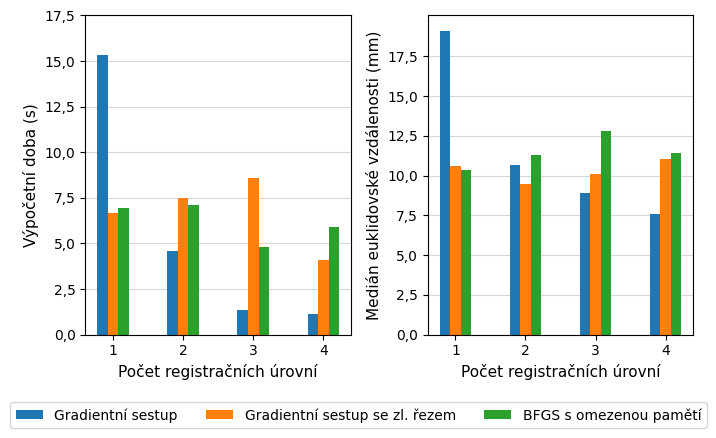

In [47]:
plotBars(regLabels[2:], exectime, errors)